# Neural Translation - Seq2Seq with Attention (English -> Norwegian)

Neural translation is the application of neural networks to perform translation between one language to another. In this notebook, I will use neural translation to translation from English to Norwegian. 

The intuitive idea behind neural translation is to: 
    - Convert the input sentence into a semantic representation 
    - Using this semantic representation, learn to sequentially predict words in the translated language.
    
For example, given the parallel sentences: "I have a dog" and "Jeg har en hund". A representation for the English sentence will be created, called $r_{\text{I have a dog}}$. Using this representation, the model will hopefully learn to maximise the following probabilities over any other word occurring:

\begin{align}
&P(\text{har} | \text{jeg}, r_{\text{I have a dog}}) \\
&P(\text{en} | \text{har}, \text{jeg}, r_{\text{I have a dog}}) \\
&P(\text{hund} | \text{en}, \text{har}, \text{jeg}, r_{\text{I have a dog}})
\end{align}
    
By learning to maximise these probabilities, we are able to reconstruct the Norwegian sentence using the English sentence -- hence performing translation.

Since a sentence can be treated as a sequential dataset, it makes sense to use RNNs to learn these probability distributions. Specifically, LSTMs or GRUs are commonly used as they are good for learning long-ranged dependencies.

## Seq2Seq
A popular method used for neural translation is Seq2Seq, which consists of two components: an encoder and a decoder. 

The encoder is responsible for converting the input language into the semantic representation and the decoder is responsible for using this semantic representation to learn and predict the output language. A diagram of the Seq2Seq model can be seen below.

The major benefit for using this type of model architecture is that it allows for variable length input to output mappings, which fits the nature language translation. Using a stand alone RNN for translation prediction would not be able to achieve this due to the fixed input to output mapping.  
<img src="images/seq2seq_ts.png">
[Courtesy of pytorch.org]

## Attention
Using vanilla Seq2Seq allows for very simple translation, but often is unable to translate large or complex sentences with great accuracy. This is largely since the semantic meaning of a sentence is getting squashed into a single fixed-length vector, acting as a bottleneck -- which can make it difficult for the decoder to retain information that may have be presented earlier on in the input sentence. 

For example, the sentence "I have a red dog that lives with me in London". The decoder may have difficulties remembering that the dog was red, since the hidden state of the RNN has been modified many times since its occurrence. This would result in a translation that perhaps retains a similar meaning, but forgets specific details.

To combat this issue, an additional module known as Attention can be added to the model. Attention allows the decoder to attend to a certain region within the input sentence when translating the output sentence, rather then using the single-fixed semantic representation of the sentence. In the example above, when looking to predict the next word in "I have a", the decoder will attend to the beginning of the sentence where 'red dog' has been recently encoded, allowing it to use a more relevant encoding to decode from. 


<img src="images/seq2seq_attention_mechanism_new.png">
[Courtesy of https://guillaumegenthial.github.io]

## Bleu Score
A metric is needed in order to evaluate the performance of the neural translator. One of the most commonly used metrics for this type of task is the Bleu (Bilingual Evaluation Understudy) Score. This essentially counts N-gram matches between the target sentence and the predicted sentence. 

For example, the Bleu-1 score would count the number of matches between single words in two sentences. 

- Target = ['Jeg', 'har', 'en' 'hund']
- Prediction = ['Jeg', 'har', 'en', 'hund']


- Target = ['Jeg', 'har', 'en' 'hund']
- Prediction = ['Jeg', 'har', 'en', 'katt']

In the first case, since all the words match, the Bleu-1 score would be 1.0. In the second case, three of the four words match, so the Bleu-1 score will be 0.75.

The Bleu-2 score is an equally weighted average between the count of 1-grams and the count of 2-grams. Again, in the first case all the 1-grams and 2-grams match up, so will give a Bleu-2 score of 1.0. For clarity, let's go through the second case: 

- 1-grams: 
    - Jeg -> Jeg (correct)
    - har -> har (correct)
    - en -> en (correct)
    - hund -> katt (incorrect)
    
    1-gram-score: 3/4


- 2-grams:
    - Jeg har -> Jeg har (correct)
    - har en -> har en (correct)
    - en hund -> en katt (incorrect)
       
    2-gram-score: 2/3

Therefore, the Bleu-2 score will be a $0.5 * \text{1-gram-score} + 0.5 * \text{2-gram-score} = 0.5 * 3/4 + 0.5 * 2/3 = 0.7083$

This easily generalises to Bleu-n and in practice the Bleu scores for $n = 1, 2, 3, 4$ are taken into account when determining the performance of a translation model. 
    
    



## Data
The data used to train the neural translation model is a set of parallel translations from English to Norwegian of subtitles from different TV shows, found on http://opus.nlpl.eu. All in all, this dataset has around 20 million translated sentences. 

Due to computational constraints, the model will be trained on around 400,000 of these sentences. This includes filtering the English sentences to maximum of length ten. The vocabulary size was also truncated to include only the top 7500 words in both English and Norwegian, significantly speeding up the training process as well as improving the performance of the model.

First and foremost, the XML/ TML file containing the sentence has to be parsed, preprocessed, and converted into a data structure that can be read by a neural network. Examples of the raw sentence data can be seen below:

```
<tu>
  <tuv xml:lang="en"><seg>A picture with a smile - and perhaps, a tear.</seg></tuv>
  <tuv xml:lang="no"><seg>Et bilde med et smil og kanskje en tåre.</seg></tuv>
</tu>
<tu>
  <tuv xml:lang="en"><seg>"Charity Hospital"</seg></tuv>
  <tuv xml:lang="no"><seg>Velferdsykehus</seg></tuv>
</tu>
<tu>
  <tuv xml:lang="en"><seg>The Woman - whose sin was motherhood.</seg></tuv>
  <tuv xml:lang="no"><seg>Kvinna - hvis synd var moderskap.</seg></tuv>
</tu>
```

Methods to extract the sentences amongst the XML, remove punctuation, capitalisation, replacing numbers, adding ```<sos>``` and ```<eos>``` tags, padding the sentences to the same length, converting the words into indices, and splitting into a training and test set can be seen below.

In [1]:
### Import necessary modules
import numpy as np
import re
import torch
import torch.nn.functional as F
import torch.nn.init as init

from torch import nn
from torch.utils.data import Dataset, DataLoader

from language import Preprocessor, Language
from main import Seq2Seq

In [2]:
def retrieve_raw_data(root_dir, translation_file, number_of_lines=2000000):
    english_sentences = []
    norwegian_sentences = []

    sentence_dict = dict()

    with open(root_dir + translation_file, 'r') as f:
        lines = f.readlines()

        for line in lines[:number_of_lines]:
            if 'tuv xml:lang="en"' in line:
                english_sentence = re.search(
                    '<seg>(.*)</seg>', line).group(1)

                english_sentences.append(english_sentence)

            if 'tuv xml:lang="no"' in line:
                norwegian_sentence = re.search(
                    '<seg>(.*)</seg>', line).group(1)

                norwegian_sentences.append(norwegian_sentence)

    return english_sentences, norwegian_sentences


def preprocess_data(english_sentences, norwegian_sentences):
    preprocessor = Preprocessor()

    preprocessed_english_sentences = []
    preprocessed_norwegian_sentences = []

    for sentence in english_sentences:
        pre_eng = preprocessor.preprocess_sentence(sentence)
        preprocessed_english_sentences.append(pre_eng)

    for sentence in norwegian_sentences:
        pre_nor = preprocessor.preprocess_sentence(sentence, sos=True, eos=True)
        preprocessed_norwegian_sentences.append(pre_nor)

    return preprocessed_english_sentences, preprocessed_norwegian_sentences


def retrieve_data(root_dir, translation_file):
    # Retrieve
    english_sentences, norwegian_sentences = retrieve_raw_data(
        root_dir, translation_file)
    
    # Preprocess
    english_sentences, norwegian_sentences = preprocess_data(
        english_sentences, norwegian_sentences)

    return english_sentences, norwegian_sentences


def indices_from_sentence(language, sentence):
    indices = []

    for word in sentence.split(' '):
        try:
            idx = language.word2idx[word]
        except(KeyError):
            idx = language.word2idx['<unk>']

        indices.append(idx)

    return indices


def sentence_from_indices(language, indices):
    sentence = []

    for index in indices:
        word = language.idx2word[index]
        sentence.append(word)

    return sentence


def convert_sentences_index(language, sentences):
    sentences_indices = []
    for sentence in sentences:
        indices = indices_from_sentence(language, sentence)
        sentences_indices.append(indices)

    sentences_indices = np.array(sentences_indices)

    return sentences_indices


def filter_sentences_by_length(english_sentences, norwegian_sentences, max_length):
    filtered_english = []
    filtered_norwegian = []

    for i in range(len(english_sentences)):
        if len(english_sentences[i].split(' ')) < max_length:
            filtered_english.append(english_sentences[i])
            filtered_norwegian.append(norwegian_sentences[i])

    return filtered_english, filtered_norwegian


def pad_sentences(sentences):
    max_length = max([len(sentence.split(' ')) for sentence in sentences])
    padded_sentences = []

    for sentence in sentences:
        words = sentence.split(' ').copy()

        while(len(words) < max_length):
            words.append('<pad>')

        words = ' '.join(words)
        padded_sentences.append(words)

    return padded_sentences

def filter_pad_sentences(english_sentences, norwegian_sentences, max_length):
    filtered_english, filtered_norwegian = filter_sentences_by_length(
    english_sentences, norwegian_sentences, max_length)
    
    padded_english_sentences = pad_sentences(filtered_english)
    padded_norwegian_sentences = pad_sentences(filtered_norwegian)
    
    return padded_english_sentences, padded_norwegian_sentences

def train_test_sentences(filtered_english, filtered_norwegian, test_size=0.01):
    number_of_sentences = len(filtered_english)
    indices = np.arange(number_of_sentences)
    
    np.random.shuffle(indices)
    
    train_indices = indices[:int(number_of_sentences * (1 - test_size))]
    test_indices = indices[int(number_of_sentences * (1 - test_size)): ]
    
    english_train_sentences = []
    norwegian_train_sentences = []
    
    english_test_sentences = []
    norwegian_test_sentences = []
  
    for index in train_indices:
        english_train_sentence = filtered_english[index]
        norwegian_train_sentence = filtered_norwegian[index]
      
        english_train_sentences.append(english_train_sentence)
        norwegian_train_sentences.append(norwegian_train_sentence)
     
    for index in test_indices:
        english_test_sentence = filtered_english[index]
        norwegian_test_sentence = filtered_norwegian[index]
      
        english_test_sentences.append(english_test_sentence)
        norwegian_test_sentences.append(norwegian_test_sentence)
    
    return english_train_sentences, norwegian_train_sentences, english_test_sentences, norwegian_test_sentences


### Use the methods above to read and preprocess parallel sentence data

In [3]:
np.random.seed(0)

# Retrieve preprocessed sentence data
english_sentences, norwegian_sentences = retrieve_data(
    './data/', 'subtitle_data.tmx')

english_language = Language('english')
norwegian_language = Language('norwegian')

# Filter by length and pad
max_length = 10
padded_english_sentences, padded_norwegian_sentences = filter_pad_sentences(english_sentences, norwegian_sentences, max_length)

# Create train and test set
english_train_sentences, norwegian_train_sentences, english_test_sentences, norwegian_test_sentences = train_test_sentences(padded_english_sentences, padded_norwegian_sentences)

# Count vocabulary in English and Norwegian sentences
for sentence in english_train_sentences:
    english_language.count_words(sentence)
    
for sentence in norwegian_train_sentences:
    norwegian_language.count_words(sentence)

# Choose top N vocabulary in both languages
N = 7500
english_language.top_n_words(N)
norwegian_language.top_n_words(N)

# Create dictionary to map words to idx
english_language.index_words()
norwegian_language.index_words()

# Convert sentences into indices
english_train_sentences_ids = convert_sentences_index(english_language, english_train_sentences)
norwegian_train_sentences_ids = convert_sentences_index(norwegian_language, norwegian_train_sentences)
english_test_sentences_ids = convert_sentences_index(english_language, english_test_sentences)
norwegian_test_sentences_ids = convert_sentences_index(norwegian_language, norwegian_test_sentences)

# Vocabulary size of English and Norwegian
english_vocab_size = english_language.vocab_size()
norwegian_vocab_size = norwegian_language.vocab_size()

print("Number of Training Sentences: %d" % len(english_train_sentences))
print("English Vocab: %d" % english_vocab_size)
print("Norwegian Vocab: %d" % norwegian_vocab_size)

Number of Training Sentences: 384209
English Vocab: 7503
Norwegian Vocab: 7501


### Examples of parallel sentences

In [4]:
for i in range(0, 10):
    english_sent = ' '.join([word for word in english_train_sentences[i].split() if word != '<pad>'])
    norwegian_sent = ' '.join([word for word in norwegian_train_sentences[i].split() if word != '<pad>'])
    
    print('English: %s' % english_sent)
    print('Norwegian: %s\n' % norwegian_sent)


English: ill knock your block off
Norwegian: <sos> jeg skal slå inn huet på deg <eos>

English: look at dad
Norwegian: <sos> se på far <eos>

English: second panther
Norwegian: <sos> så panter <eos>

English: bobs a dummy
Norwegian: <sos> bob er en treskalle <eos>

English: choya
Norwegian: <sos> så hva kaller de deg <eos>

English: thats destroying evidence
Norwegian: <sos> det der er å ødelegge bevis <eos>

English: twice eight hours nearly nine hours
Norwegian: <sos> to ganger eight timer <eos>

English: my parents have a farm
Norwegian: <sos> foreldrene mine har en gård på landet <eos>

English: elisabet what have you got there
Norwegian: <sos> elisabet hva har du der <eos>

English: he died in hamburg last november
Norwegian: <sos> han døde i hamburg i november <eos>



### Instantiate and train (or load) model

A seq2seq model with attention was trained on Colab using a GPU. The architecture was as follows: 

Encoder: 
    - Embedding Layer (FC: 256 Neurons + ReLU)
    - GRU (1 Layer, 256 Neurons)

Decoder: 
    - Embedding Layer (FC: 256 Neurons + ReLU)
    - GRU (1 Layer, 256 Neurons)

Early stopping was used to determine when to stop training. The criteria used was if the Bleu-1 score stopped improving after 1000 batches. 

In [11]:
from translator import Translator
cuda = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

translator = Translator(english_language, norwegian_language, cuda='cpu')
train = False

file_load_name = 'utils/translator_model_h256_l1_e256_c10_v7p5k_att'

# Train model
if train:
    translator.train(X_train=english_train_sentences_ids,
                     y_train=norwegian_train_sentences_ids,
                     X_test=english_test_sentences_ids,
                     y_test=norwegian_test_sentences_ids,
                     file_load_name=file_load_name)

# Load pre-trained model 
else:
    translator.load_model(file_load_name)

### Visualisation of the loss & BLEU curves during training

<IPython.core.display.Javascript object>


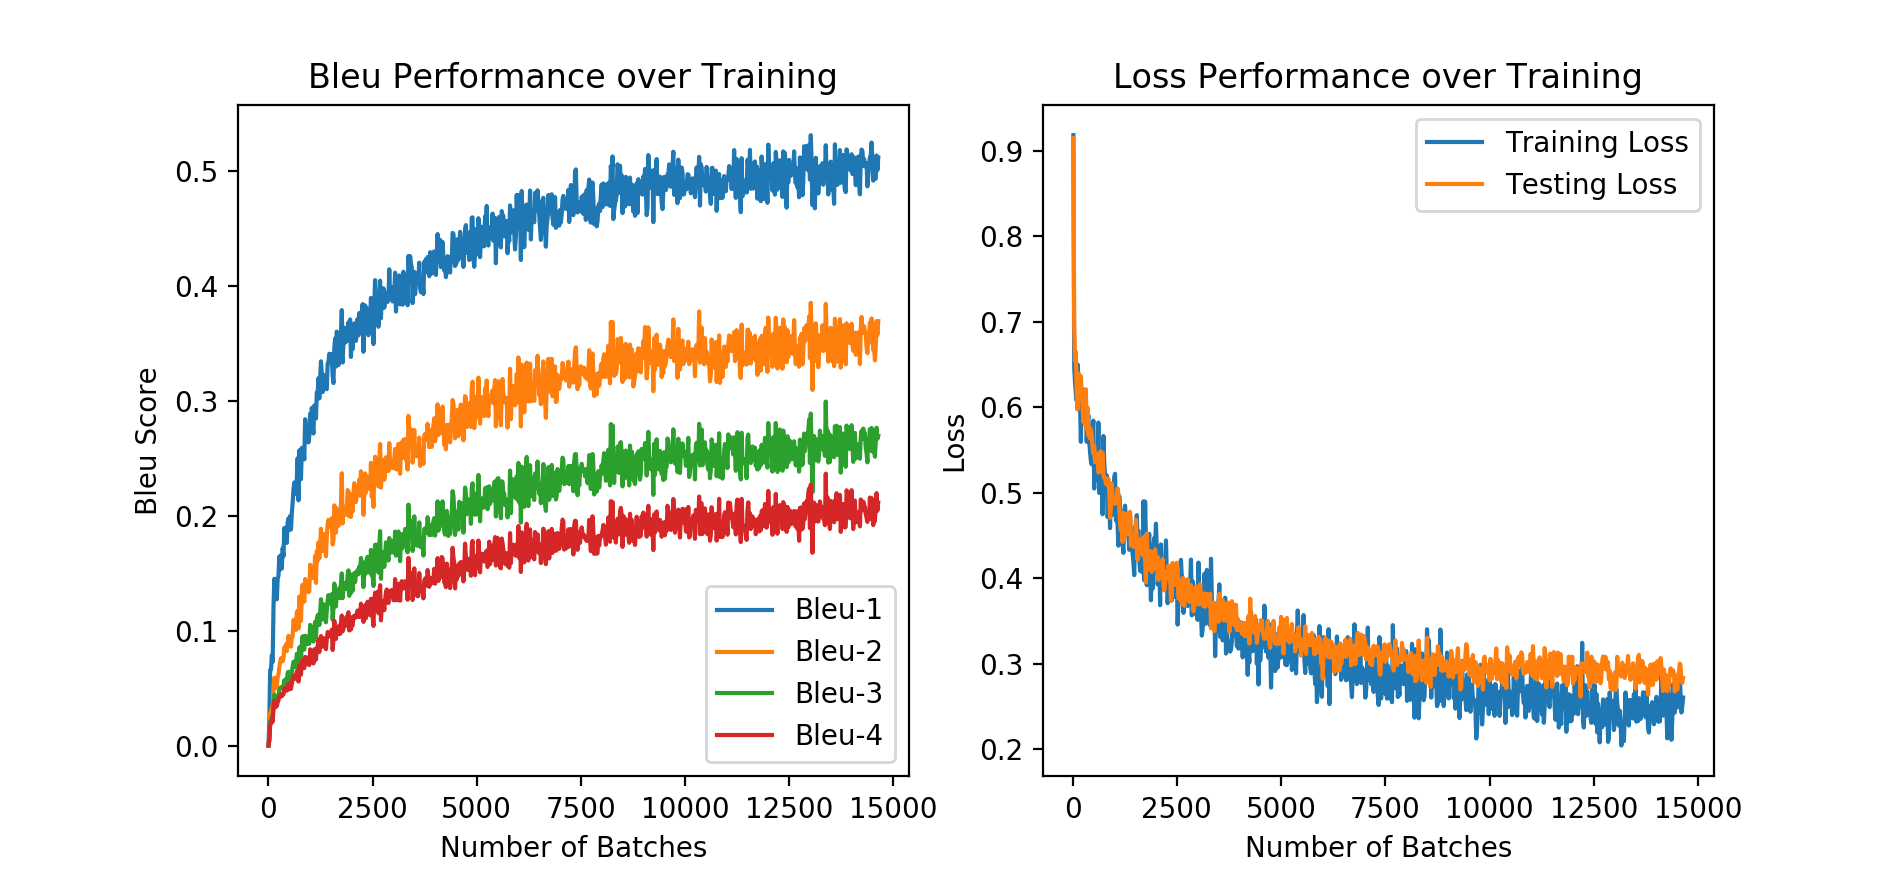

In [13]:
%matplotlib notebook
import matplotlib.pyplot as plt
import pickle as pkl

with open('utils/metric_dict.pickle', 'rb') as f:
    metric_dict = pkl.load(f)

bleu1 = metric_dict['bleu1']
bleu2 = metric_dict['bleu2']
bleu3 = metric_dict['bleu3']
bleu4 = metric_dict['bleu4']
training_loss = metric_dict['training_loss']
testing_loss = metric_dict['testing_loss']

batches = np.arange(0, len(bleu1) * 20, 20)

fig, ax = plt.subplots(1, 2)

ax[0].plot(batches, bleu1, label='Bleu-1')
ax[0].plot(batches, bleu2, label='Bleu-2')
ax[0].plot(batches, bleu3, label='Bleu-3')
ax[0].plot(batches, bleu4, label='Bleu-4')

ax[0].set_xlabel('Number of Batches')
ax[0].set_ylabel('Bleu Score')
ax[0].set_title('Bleu Performance over Training')
ax[0].legend()

ax[1].plot(batches[1:], training_loss[1:], label='Training Loss')
ax[1].plot(batches[1:], testing_loss[1:], label='Testing Loss')
ax[1].set_xlabel('Number of Batches')
ax[1].set_ylabel('Loss')
ax[1].set_title('Loss Performance over Training')
ax[1].legend()
plt.show()


### Examples of translations with the model

In [7]:
for i in range(1000, 1005):
    english_sent = ' '.join([word for word in english_test_sentences[i].split() if word != '<pad>'])
    norwegian_sent = ' '.join([word for word in norwegian_test_sentences[i].split() if word != '<pad>' and word != '<sos>' and word != '<eos>'])
    translated_sent = translator.translate(english_sent)
    
    bleu1, bleu2, bleu3, bleu4 = translator.bleu_score(norwegian_sent.split(' '), translated_sent.split(' '))
        
    print('English: %s' % english_sent)
    print('Norwegian: %s' % norwegian_sent)
    print('Translation: %s\n' % translated_sent)
    print('Bleu-1: %.4f\nBleu-2: %.4f\nBleu-3: %.4f\nBleu-4: %.4f\n' % (bleu1, bleu2, bleu3, bleu4))
    print('------------------------\n')

English: hi david
Norwegian: hei david
Translation: david

Bleu-1: 0.3679
Bleu-2: 0.1163
Bleu-3: 0.0793
Bleu-4: 0.0654

------------------------

English: he moves around a lot
Norwegian: han flytter mye rundt
Translation: han beveger seg mye rundt en gang

Bleu-1: 0.4286
Bleu-2: 0.2673
Bleu-3: 0.1126
Bleu-4: 0.0773

------------------------

English: ill pay
Norwegian: jeg skal betale
Translation: jeg betaler

Bleu-1: 0.3033
Bleu-2: 0.1356
Bleu-3: 0.1037
Bleu-4: 0.0907

------------------------

English: i tried to scare him off with bullets
Norwegian: jeg prøvde å skremme ham vekk med kuler
Translation: jeg prøvde å skremme ham med kuler

Bleu-1: 0.8669
Bleu-2: 0.7913
Bleu-3: 0.6880
Bleu-4: 0.6130

------------------------

English: he was in his study
Norwegian: han var på kontoret sitt
Translation: han var i <unk>

Bleu-1: 0.3894
Bleu-2: 0.3179
Bleu-3: 0.1579
Bleu-4: 0.1323

------------------------



### Visualisation of the model's attention mechanism

When translating a sentence, we can have a look at the attention matrix weights to get an idea on where the model is attending its focus when predicting a translated word. 

Below are two examples of such matrices, in the form of a heatmap, for the sentences:
- where is your house -> hvor er ditt hus
- i dont like your friend -> jeg liker ikke din venn

The x-axis displays the English words that the model is trying to translate and the y-axis shows the model's choice on translation. For each translated word, an attention weight is given to each word in the input sentence showing what the model thought was important to attend to. 

In the first example, we can see that the sentence is almost a simple 1-to-1 mapping from English to Norwegian, as the attention matrix is almost diagonal. An interesting thing to note is when the model decides on the translation of the possessive pronoun 'ditt'. In Norwegian, possessive pronouns change depending on the gender of the noun that they're attached to. In this case, 'hus' (house) has a neuter gender and therefore the possessive pronoun is 'ditt' (as opposed to 'din' for a masculine gendered noun). Therefore, in order for the model to correctly predict the translation of this sentence, it needs to take into account the noun that the possessive pronoun is attached to. This is reflected in the attention mechanism, where the model attends to both 'your' and 'house' when predicting 'ditt'. 

In the second example, we see this pattern again where the model attends to both 'your' and 'friend' when predicting the possessive pronoun. Another interesting thing to note is that the attention matrix is clearly not diagonal -- in other words, the order of the English sentence does not follow the order of the Norwegian sentence. In Norwegian, negation of a verb happens when they are followed by the word 'ikke', which is the opposite to what happens in English. In this case, 'to not like' is translated to 'liker ikke' (like not). This, again, is reflected in the attention matrix when translating (like -> liker) and (dont -> ikke) and is one reason why the matrix is not diagonal.

In [8]:
def plot_attention_matrix(sentence, translator):
    translation = translator.translate(sentence)

    print('English: %s' % sentence)
    print('Translation: %s' % translation)
    
    m = translator.get_attention_matrix(sentence)

    fig, ax = plt.subplots(1, 1)
    img = ax.imshow(m[:-1])
    ax.set_xticks(np.arange(len(sentence.split(' '))))
    ax.set_yticks(np.arange(len(translation.split(' '))))
    ax.set_xticklabels(sentence.split(' '))
    ax.set_yticklabels(translation.split(' '))
    fig.colorbar(img)
    plt.show()

English: where is your house
Translation: hvor er ditt hus


<IPython.core.display.Javascript object>


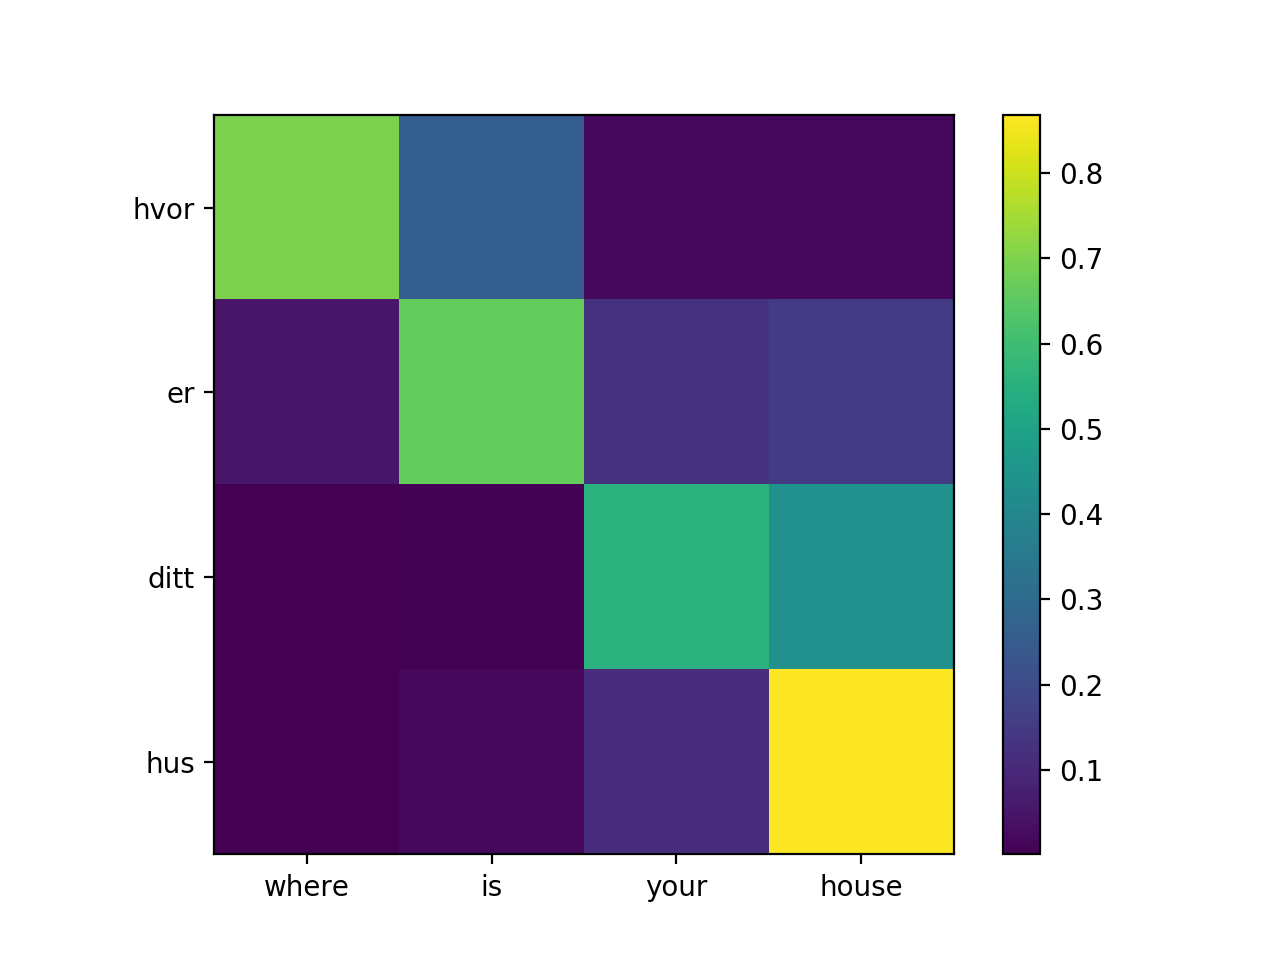

English: i dont like your friend
Translation: jeg liker ikke din venn


<IPython.core.display.Javascript object>


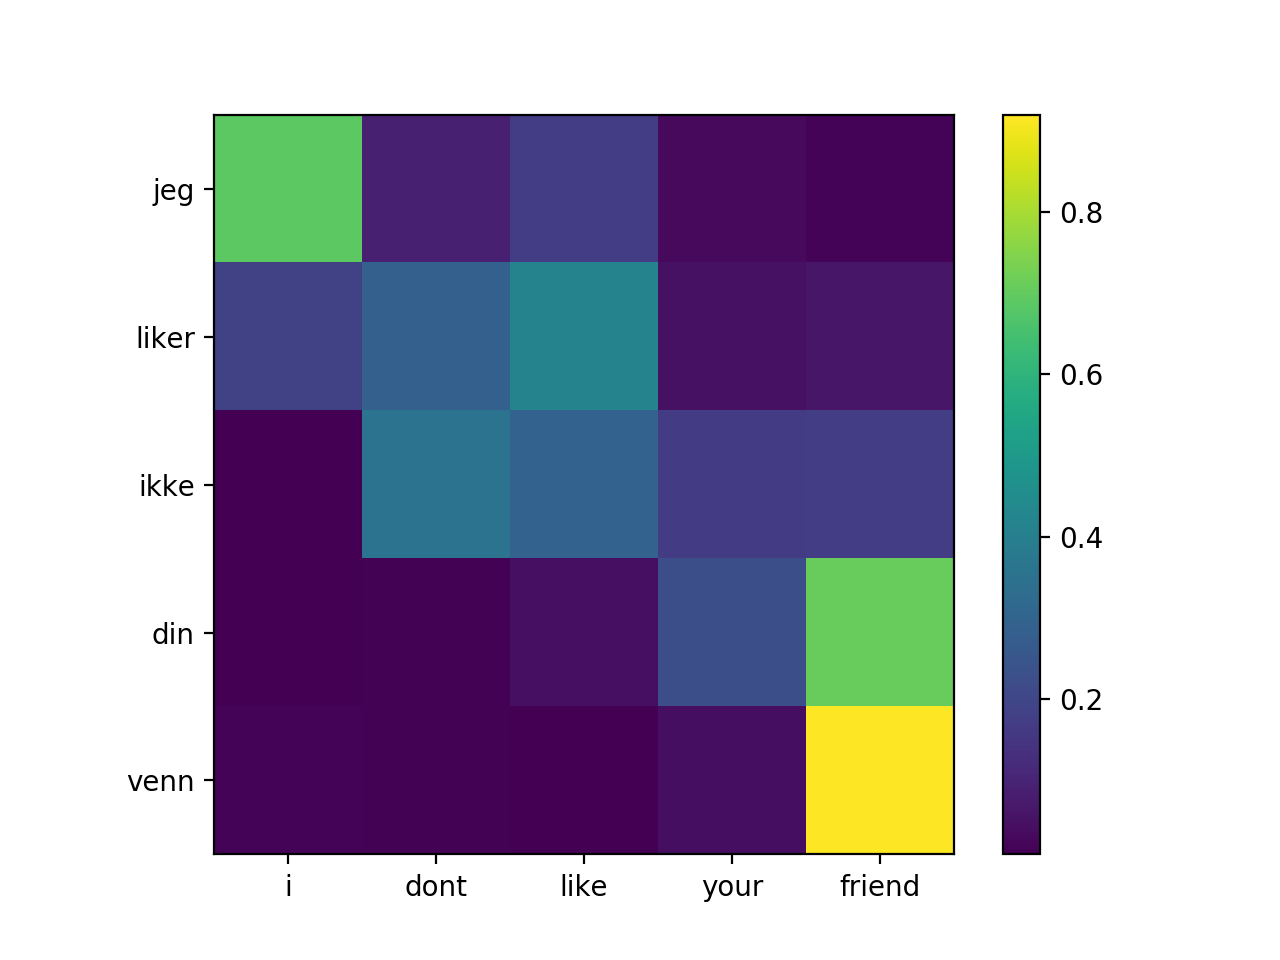

In [9]:
%matplotlib notebook

sentences = ['where is your house', 'i dont like your friend']

for sentence in sentences:
    plot_attention_matrix(sentence, translator)